Part 1: Describe training. Different ways of training, generalization across gains. Bias and variance as a function of Delta s and gains (think abpout how to plot smartly, to avoid having too many plots)
    
Setup:

In [89]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import pandas as pd
import pickle
import time
import multiprocessing as mp

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

In [90]:
def cartesian(arrays, out=None):
    """Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """
    arrays = [np.asarray(x) for x in arrays]
    shape = (len(x) for x in arrays)
    dtype = arrays[0].dtype

    ix = np.indices(shape)
    ix = ix.reshape(len(arrays), -1).T

    if out is None:
        out = np.empty_like(ix, dtype=dtype)

    for n, arr in enumerate(arrays):
        out[:, n] = arrays[n][ix[:, n]]

    return out

Generate data:

In [91]:
def random_s(ndata, sort):
    s = np.random.rand(2, ndata) * 120 - 60
    if sort:
        s = np.sort(s, axis=0)
    return s[0], s[1]

def random_c(ndata, ndims, low, high, sort):
    c_range = high - low
    if ndims == 1:
        c = np.random.rand(ndims, ndata)[0] * c_range + low
    else:
        c = np.random.rand(ndims, ndata) * c_range + low
    if sort:
        c = np.sort(c, axis=0)
    return c
    
def generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, noise, sort, s_0, s_1, c_0, c_1, c_50=13.1):
    c_rms = np.sqrt(np.square(c_0) + np.square(c_1))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, s, c

def generate_trainset(ndata, highlow=False, discrete_c=None, low=.3, high=.7, r_max=10):
    s_0, s_1 = random_s(ndata, True)
    if highlow:
        c_arr = np.concatenate((np.ones((ndata/2, 2)) * low, np.ones((ndata/2, 2)) * high), axis=0)
        np.random.shuffle(c_arr)
        c_0, c_1 = c_arr.T
    elif discrete_c:
        if type(discrete_c) == int:
            cs = np.linspace(low, high, discrete_c)
            perm_cs = cartesian((cs, cs))
        else:
            perm_cs = cartesian(discrete_c)
        c_arr = np.repeat(perm_cs, ndata/(discrete_c**2), axis=0)
        np.random.shuffle(c_arr)
        c_0, c_1 = c_arr.T
        print ndata/(discrete_c**2), "trials per contrast level"
        if ndata%(discrete_c**2) != 0:
            print "Not divisible, only generated", ndata / (discrete_c**2) * (discrete_c**2), "trials"
        ndata = ndata / (discrete_c**2) * (discrete_c**2)
    else:
        c_0, c_1 = np.ones((2, ndata)) * .5
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_testset(ndata, stim_0=None, stim_1=None, con_0=None, con_1=None, discrete_c=None, low=.5, high=.5, r_max=10):
    if con_0:
        c_0 = np.ones(ndata) * con_0
        c_1 = np.ones(ndata) * con_1
    else:
        c_range = high - low
        if discrete_c:
            if type(discrete_c) == int:
                cs = np.linspace(low, high, discrete_c)
                perm_cs = cartesian((cs, cs))
            else:
                perm_cs = cartesian(discrete_c)
            c_0, c_1 = np.repeat(perm_cs, ndata/(discrete_c**2), axis=0).T
            print ndata/(discrete_c**2), "trials per contrast level"
            if ndata%(discrete_c**2) != 0:
                print "Not divisible, only generated", ndata / (discrete_c**2) * (discrete_c**2), "trials"
            ndata = ndata / (discrete_c**2) * (discrete_c**2)
        else:
            c_0, c_1 = np.random.rand(2, ndata) * c_range + low
    if not stim_0:
        s_0, s_1 = random_s(ndata, True)
    else:
        s_0, s_1 = np.ones((2, ndata))
        s_0 = s_0 * stim_0
        s_1 = s_1 * stim_1
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_trainset_cat(ndata, low=.3, high=1.3, crange=.5, r_max=10):
    numvec = np.random.binomial(1, .5, size=ndata).astype(int)
    c_0 = random_c(ndata, 1, high, high+crange, True)
    c_1 = random_c(ndata, 1, low, low+crange, True)
    s_0, s_1 = np.random.rand(2, ndata) * 120 - 60
    r, numvec, s, c  = generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, "poisson", s_0, s_1, c_0, c_1)
    y = s[range(ndata), numvec]
    return r, y, s, c, numvec 
    
def generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, noise, s_0, s_1, c_0, c_1):
    c0vec = c_0 * np.ones(ndata)
    c1vec = c_1 * numvec
    c_rms = np.sqrt(np.square(c0vec) + np.square(c1vec))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c0vec * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c1vec * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)/(c_rms)
    #r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, numvec, s, c 

Posterior computation:

In [107]:
def lik_means(s_1, s_2, c_0=.5, c_1=.5, sprefs=sprefs, sigtc_sq=sigtc_sq, r_max=10):
    sprefs_data = np.tile(sprefs, (len(s_1), 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_2, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    r = r_max * (stim_0 + stim_1)
    return r.T
def posterior(r, means, s1_grid, s2_grid):
    ns_liks = poisson.pmf(r, mu=means)
    stim_liks = np.prod(ns_liks, axis=1)
    #p_s = 2/14400
    #logp_s = np.log(p_s)
    logp_s = -3.8573325
    #p_c = 1/9
    #logp_c = np.log(p_c)
    logp_c = -0.95424250943
    loglik = np.sum(np.log(ns_liks), axis=1)
    mean1 = np.sum(s1_grid * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    mean2 = np.sum(s2_grid * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    expsquare1 = np.sum(np.square(s1_grid) * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    expsquare2 = np.sum(np.square(s2_grid) * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    var1 = expsquare1 - np.square(mean1)
    var2 = expsquare2 - np.square(mean2)
    return mean1, mean2, var1, var2
def posterior_setup(low=.3, high=.7, discrete_c = 3, num_s=100, r_max=10):
    grid = np.linspace(-60, 60, num_s)
    s1s = np.concatenate([[grid[i]]*(num_s-i) for i in range(num_s)])
    cs = np.linspace(low, high, discrete_c)
    s1_grid, c1_grid, c2_grid = cartesian((s1s, cs, cs)).T
    s2s = np.concatenate([grid[i:num_s+1] for i in range(num_s)])
    s2_grid = np.repeat(s2s, (discrete_c**2), axis=0)
    means = lik_means(s1_grid, s2_grid, c_0=c1_grid, c_1=c2_grid, r_max=r_max)
    partial_post = partial(posterior, means=means, s1_grid=s1_grid, s2_grid=s2_grid)
    return partial_post
def get_posteriors(r, post_func):
    posteriors = {'mean_s1': None, 'mean_s2': None, 'var_s1': None, 'var_s2': None}
    p = np.array([post_func(r[i]) for i in range(len(r))]).T
    posteriors['mean_s1'], posteriors['mean_s2'], posteriors['var_s1'], posteriors['var_s2'] = p
    return posteriors
def get_posteriors_pool(r, post_func):
    pool = mp.Pool(processes=8)
    posteriors = {'mean_s1': None, 'mean_s2': None, 'var_s1': None, 'var_s2': None}
    p = np.array(pool.map(post_func, r)).T
    posteriors['mean_s1'], posteriors['mean_s2'], posteriors['var_s1'], posteriors['var_s2'] = p
    return posteriors

Network computation:

In [208]:
"""
Multilayer ReLU net
"""

def relu(x):
    return theano.tensor.switch(x<0, 0, x)

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.nnet.sigmoid):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        if W is None:
            W_values = (1/np.sqrt(n_in)) * np.random.randn(n_in, n_out)
            
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

class MLP(object):


    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        self.hiddenLayer1 = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            #activation=T.nnet.sigmoid
            activation=relu
        )
        
        self.hiddenLayer2 = HiddenLayer(
            rng=rng,
            input=self.hiddenLayer1.output,
            n_in=n_hidden,
            n_out=n_out,
            #activation=relu
            activation=None
        )
        
        self.y_pred = self.hiddenLayer2.output
        
        # the parameters of the model are the parameters of the two layers it is made out of
        self.params = self.hiddenLayer1.params + self.hiddenLayer2.params
    
    def get_params(self):

        params = {}
        for param in self.params:
            name = param.name
            if name in params:
                name = name, 2
            params[name] = param.get_value()
        return params
    
    def mse(self, y):
        # error between output and target
        if y.ndim == 1:
            se = (self.y_pred.T - y)**2
        else:
            se = T.sum((self.y_pred - y)**2, axis=1)
        return T.mean(se)
        
    
    def valid_mse(self, y):
        if y.ndim == 1:
            se = (self.y_pred.T * 90 - y * 90)**2
        else:
            se = T.sum((self.y_pred * 90 - y * 90)**2, axis=1)
        return T.mean(se)

    
class Perceptron(object):


    def __init__(self, rng, input, n_in, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        self.layer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_out,
            #activation=T.nnet.sigmoid
            activation=relu
        )
        
        self.y_pred = self.layer.output
        
        # the parameters of the model are the parameters of the two layers it is made out of
        self.params = self.layer.params
        
    def get_params(self):

        params = {}
        for param in self.params:
            name = param.name
            if name in params:
                name = name, 2
            params[name] = param.get_value()
        return params
    
    def mse(self, y):
        # error between output and target
        if y.ndim == 1:
            se = (self.y_pred.T - y)**2
        else:
            se = T.sum((self.y_pred - y)**2, axis=1)
        return T.mean(se)
    
    def valid_mse(self, y):
        return mse(self, y)
        

def shared_dataset(data_xy, borrow=True):
    """ Function that loads the dataset into shared variables
    """

    data_x, data_y = data_xy[:2]
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype='float32'),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype='float32'),
                             borrow=borrow)
    return shared_x, shared_y

def shared_dataset_x(data_x, borrow=True):
    """ Function that loads the dataset into shared variables
    """
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype='float32'),
                             borrow=borrow)
    return shared_x

def train_nn(train_dataset, valid_dataset=None, n_hidden=20, learning_rate=0.01, n_epochs=10, batch_size=20, linear=False, mult_ys=True, rho=0, nesterov=True, mu=0, n_in=61, n_out=2):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

   """
    train_set_x, train_set_y = shared_dataset(train_dataset)
    if valid_dataset:
        valid_set_x, valid_set_y = shared_dataset(valid_dataset)
    
    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
    
    
    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print '... building the model'

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.fmatrix('x')   # input data from visual neurons
    if n_out == 1:
        y = T.fvector('y') # ground truth
    else:
        y = T.fmatrix('y')  # ground truth

    rng = np.random.RandomState(1234)

    # construct the MLP class
    if linear:
        nn = Perceptron(rng=rng, input=x, n_in=n_in, n_out=n_out)
    else:
        nn = MLP(rng=rng, input=x, n_in=n_in, n_hidden=n_hidden, n_out=n_out)
    
    cost = nn.mse(y)
    
    def RMSprop(cost, params, learning_rate=0.001, rho=0.9, epsilon=1e-6, mu=0, nesterov=False):
        gparams = T.grad(cost, params)
        updates = []
        for p, g in zip(params, gparams):
            v = theano.shared(p.get_value() * 0.)
            ms = theano.shared(p.get_value() * 0.)
            ms_new = rho * ms + (1 - rho) * g ** 2
            gradient_scaling = T.sqrt(ms_new + epsilon)
            g = g / gradient_scaling
            """
            (1) v_t = mu * v_t-1 - lr * gradient_f(params_t)
            or
            classic
            (2) params_t = params_t-1 + v_t
            nesterov
            (7) params_t = params_t-1 + mu * v_t - lr * gradient_f(params_t-1)
            (8) params_t = params_t-1 + mu**2 * v_t-1 - (1+mu) * lr * gradient_f(params_t-1)
            """
            v_new = mu * v - (1 - mu) * learning_rate * g
            if nesterov:
                p_new = p + mu * v_new - (1 - mu) * learning_rate * g
            else:
                p_new = p + v_new
            updates.append((ms, ms_new))
            updates.append((v, v_new))
            updates.append((p, p_new))
                
        return updates
    
    if rho:
        updates = RMSprop(cost, nn.params, learning_rate=learning_rate, rho=rho, mu=mu, nesterov=nesterov)
    else:
        # compute the gradient of cost with respect to theta (sotred in params)
        # the resulting gradients will be stored in a list gparams
        gparams = [T.grad(cost, param) for param in nn.params]

        # specify how to update the parameters of the model as a list of
        # (variable, update expression) pairs

        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(nn.params, gparams)
        ]
    
    def inspect_inputs(i, node, fn):
        print i, node, "input(s) value(s):", [input[0] for input in fn.inputs]

    def inspect_outputs(i, node, fn):
        print "output(s) value(s):", [output[0] for output in fn.outputs]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    if mult_ys:
        valid_mse = nn.valid_mse(y)
    else:
        valid_mse = cost
    
    validate_model = theano.function(
        inputs=[index],
        outputs=valid_mse,
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    ###############
    # TRAIN MODEL #
    ###############
    print '... training'

    epoch = 0 

    if valid_dataset:
        valid_mse = np.zeros(n_epochs)

    while (epoch < n_epochs):
        for minibatch_index in xrange(n_train_batches):
            
            minibatch_avg_cost = train_model(minibatch_index)
            
        if valid_dataset:
            validation_losses = [validate_model(i) for i in xrange(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)
            valid_mse[epoch] = this_validation_loss
            print(
                'epoch %i, validation error %f' %
                (
                    epoch,
                    this_validation_loss,
                )
            )
            
        epoch = epoch + 1

    if valid_dataset:
        return nn, x, valid_mse
    return nn, x

def test_nn(nn, nnx, test_data):
    print 'testing'
    test_batch_size = 1
    if len(test_data) == 1:
        test_set_x = shared_dataset_x(test_data)
    else:
        test_set_x, test_set_y = shared_dataset(test_data)
    index = T.lscalar()  # index to a [mini]batch
    x = nnx   # input data from visual neurons
    test_model = theano.function(
        inputs=[index],
        outputs=nn.y_pred,
        givens={
            x: test_set_x[index * test_batch_size: (index + 1) * test_batch_size]
        },
    )
    
    if test_set_y:
        true_ys = test_set_y.get_value()
        n_preds = len(true_ys)
    else:
        n_preds = len(test_set_x.get_value())
    pred_ys = np.zeros((n_preds, 2))
    for i in range(n_preds):
        pred_ys[i] = test_model(i)
        #print test_model(i)[0], true_ys[i]
        #print test_model(i)[0] * 90, true_ys[i]
    
    #print nn.get_params()
    return pred_ys, true_ys

Train networks:

In [43]:
train_data = {}
td_sizes = [2700, 27000, 270000]
td_types = [True, False]
for td_s in td_sizes:
    for td_t in td_types:
        train_data[td_s, td_t] = generate_trainset(td_s, highlow=td_t, discrete_c=3, low=.3, high=.7)
valid_data = generate_testset(900, discrete_c=3, low=.3, high=.7)
lrs = [.01, .005, .001, .0005, .0001, .00001]
rhos = [0, .75, .9, .95, .99, .999]
mus = [0, .75, .9, .95, .99, .999]
nests = [True, False]
nrows = len(td_sizes) * len(td_types) * len(lrs) * len(rhos) * len(mus) * len(nests)
nn_df = pd.DataFrame(index=np.arange(0, nrows), columns=('training_type', 'training_size', 'lr', 'rho', 'mu', 'nest', 'valid_nn'))
nns = {}
ind = 0
for td_s in td_sizes:
    for td_t in td_types:
        for lr in lrs:
            for rho in rhos:
                for mu in mus:
                    for n in nests:
                        nn, nnx, valid_nn = train_nn(train_data[td_s, td_t], valid_dataset=valid_data, n_hidden=20, learning_rate=lr, n_epochs=100, rho=rho, mu=mu, nesterov=n)
                        nn_df.loc[ind] = [td_s, td_t, lr, rho, mu, n, valid_nn[99]]
                        nns[td_s, td_t, lr, rho, mu, n] = nn, nnx, valid_nn
                        ind += 1

300 trials per contrast level
3000 trials per contrast level
30000 trials per contrast level
100 trials per contrast level
... building the model
... training
epoch 0, validation error 974.018282
epoch 1, validation error 715.963227
epoch 2, validation error 622.572728
epoch 3, validation error 565.799241
epoch 4, validation error 529.839920
epoch 5, validation error 507.512102
epoch 6, validation error 489.247489
epoch 7, validation error 477.050087
epoch 8, validation error 466.878515
epoch 9, validation error 461.860719
epoch 10, validation error 460.742751
epoch 11, validation error 460.542752
epoch 12, validation error 459.028885
epoch 13, validation error 456.767129
epoch 14, validation error 455.623355
epoch 15, validation error 453.135185
epoch 16, validation error 450.831577
epoch 17, validation error 448.938438
epoch 18, validation error 448.080171
epoch 19, validation error 445.987136
epoch 20, validation error 443.610451
epoch 21, validation error 440.099394
epoch 22, valid

KeyboardInterrupt: 

Pickling:

In [ ]:
output = (nn_df, nns)
pkl_file = open('nn_optim.pkl', 'wb')
pickle.dump(output, pkl_file)
pkl_file.close()

In [15]:
pkl_file = open('nn_optim.pkl', 'rb')
nn_df, nns = pickle.load(pkl_file)

In [20]:
nn_df.sort('valid_nn', ascending=1)[0:15]

,lr,rho,mu,nest,valid_nn
265,0.0005,0.99,0,False,23.62539
270,0.0005,0.99,0.95,True,24.06649
282,0.0005,0.999,0.95,True,25.07611
268,0.0005,0.99,0.9,True,25.766
208,0.001,0.999,0.9,True,26.92505
184,0.001,0.95,0.9,True,27.41485
259,0.0005,0.95,0.95,False,27.6143
228,0.0005,0.75,0,True,27.88683
283,0.0005,0.999,0.95,False,28.00329
159,0.001,0.75,0.75,False,28.20586


In [ ]:
train_data_equal = generate_trainset(27000, discrete_c=1, low=.5, high=.5)
train_data_all = generate_trainset(27000, discrete_c=3, low=.3, high=.7)
train_data_high_low = generate_trainset(27000, highlow=True, low=.3, high=.7)
valid_data = generate_testset(900, discrete_c=3, low=.3, high=.7)
nn_equal, nnx_equal, valid_nn_equal = train_nn(train_data_equal, valid_dataset=valid_data, n_hidden=20, learning_rate=.0005, n_epochs=100, rho=.99, mu=.95, nesterov=True)
nn_all, nnx_all, valid_nn_all = train_nn(train_data_all, valid_dataset=valid_data, n_hidden=20, learning_rate=.0005, n_epochs=100, rho=.99, mu=.95, nesterov=True)
nn_high_low, nnx_high_low, valid_nn_high_low = train_nn(train_data_high_low, valid_dataset=valid_data, n_hidden=20, learning_rate=.0005, n_epochs=100, rho=.99, mu=.95, nesterov=True)

In [228]:
def get_statistics(s1, s2, preds):
    mean_s1 = np.mean(preds[0])
    mean_s2 = np.mean(preds[1])
    bias_s1 = mean_s1 - s1
    bias_s2 = mean_s2 - s2
    mse = np.mean((preds[0] - s1)**2 + (preds[1] - s2)**2)
    covmat = np.cov(preds)
    var_s1 = covmat[0, 0]
    var_s2 = covmat[1, 1]
    cov = covmat[0, 1]
    corr = cov / (np.sqrt(var_s1) * np.sqrt(var_s2))
    stats = {'mean_s1': mean_s1, 'mean_s2': mean_s2, 'bias_s1': bias_s1, 'bias_s2': bias_s2, 'var_s1': var_s1, 'var_s2': var_s2, 'cov': cov, 'corr': corr, 'mse': mse}
    return stats

In [201]:
s1 = -30
ndata = 100
num_deltas = 60
c_0 = .5
c_1 = [.3, .5, .7]
nn_all_stats = {'mean_s1': np.zeros((num_deltas, len(c_1))), 
                'mean_s2': np.zeros((num_deltas, len(c_1))), 
                'bias_s1': np.zeros((num_deltas, len(c_1))), 
                'bias_s2': np.zeros((num_deltas, len(c_1))), 
                'var_s1': np.zeros((num_deltas, len(c_1))), 
                'var_s2': np.zeros((num_deltas, len(c_1))), 
                'cov': np.zeros((num_deltas, len(c_1))), 
                'corr': np.zeros((num_deltas, len(c_1))),
                'posts': {}
                }
nn_high_low_stats = {'mean_s1': np.zeros((num_deltas, len(c_1))), 
                'mean_s2': np.zeros((num_deltas, len(c_1))), 
                'bias_s1': np.zeros((num_deltas, len(c_1))), 
                'bias_s2': np.zeros((num_deltas, len(c_1))), 
                'var_s1': np.zeros((num_deltas, len(c_1))), 
                'var_s2': np.zeros((num_deltas, len(c_1))), 
                'cov': np.zeros((num_deltas, len(c_1))), 
                'corr': np.zeros((num_deltas, len(c_1))),
                'posts': {}
                }

for delta_s in range(num_deltas):
    for c in range(len(c_1)):
        test_data = generate_testset(ndata, stim_0=s1, stim_1=s1+delta_s, con_0=c_0, con_1=c_1[c])
        nn_preds_all, _ = test_nn(nn_all, nnx_all, test_data)
        nn_preds_all = nn_preds_all.T * 90
        nn_preds_high_low, _ = test_nn(nn_high_low, nnx_high_low, test_data)
        nn_preds_high_low = nn_preds_high_low.T * 90
        stats_1 = get_statistics(s1, s1 + delta_s, nn_preds_all)
        stats_2 = get_statistics(s1, s1 + delta_s, nn_preds_high_low)

        nn_all_stats['mean_s1'][delta_s][c] = stats_1['mean_s1']
        nn_all_stats['mean_s2'][delta_s][c] = stats_1['mean_s2']
        nn_all_stats['bias_s1'][delta_s][c] = stats_1['bias_s1']
        nn_all_stats['bias_s2'][delta_s][c] = stats_1['bias_s2']
        nn_all_stats['var_s1'][delta_s][c] = stats_1['var_s1']
        nn_all_stats['var_s2'][delta_s][c] = stats_1['var_s2']
        nn_all_stats['cov'][delta_s][c] = stats_1['cov']
        nn_all_stats['corr'][delta_s][c] = stats_1['corr']
        
        nn_high_low_stats['mean_s1'][delta_s][c] = stats_2['mean_s1']
        nn_high_low_stats['mean_s2'][delta_s][c] = stats_2['mean_s2']
        nn_high_low_stats['bias_s1'][delta_s][c] = stats_2['bias_s1']
        nn_high_low_stats['bias_s2'][delta_s][c] = stats_2['bias_s2']
        nn_high_low_stats['var_s1'][delta_s][c] = stats_2['var_s1']
        nn_high_low_stats['var_s2'][delta_s][c] = stats_2['var_s2']
        nn_high_low_stats['cov'][delta_s][c] = stats_2['cov']
        nn_high_low_stats['corr'][delta_s][c] = stats_2['corr']

testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing
testing


In [94]:
def train_nns(i, params, train_data, valid_data):
    lr, rho, mu, n = params[i]
    nn, nnx, valid_nn = train_nn(train_data, valid_dataset=valid_data, n_hidden=100, learning_rate=lr, n_epochs=100, rho=rho, mu=mu, nesterov=n)
    return [lr, rho, mu, n, valid_nn[99]], (nn, nnx, valid_nn)

In [123]:
lrs = np.array([.01, .005, .001, .0005, .0001, .00001])
rhos = np.array([0, .75, .9, .95, .99, .999])
mus = np.array([0, .75, .9, .95, .99, .999])
nests = np.array([True, False])
cs = np.array([1, 2, 4])
params = cartesian([lrs, rhos, mus, nests, cs])

In [186]:
import os
nns = {}
nn_df = pd.DataFrame(index=np.arange(0, nrows), columns=('c', 'lr', 'rho', 'mu', 'nest', 'valid_nn'))
for i in range(1, len(params)):
    lr, rho, mu, n, c = params[i]
    file_name = 'output_nn_optim/nn_optim' + str(i+1) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_nn = pickle.load(pkl_file)
        nns[c, lr, rho, mu, n] = (nn, nnx, valid_nn)
        nn_df.loc[i] = [c, lr, rho, mu, n, valid_nn[99]]

In [140]:
nn_df.sort('valid_nn', ascending=1)
nn_c1 = nn_df[nn_df['c'] == 1]
nn_c2 = nn_df[nn_df['c'] == 2]
nn_c4 = nn_df[nn_df['c'] == 4]

In [220]:
train_data = generate_trainset(270000, discrete_c=1, low=2, high=2, r_max=1)
valid_data = generate_testset(900, discrete_c=1, low=2, high=2, r_max=1)
nn, nnx, valid_mse = train_nn(train_data, valid_dataset=valid_data, n_hidden=100, learning_rate=0.0001, n_epochs=100, rho=.9, mu=.99, nesterov=True)

270000 trials per contrast level
900 trials per contrast level
... building the model
... training
epoch 0, validation error 73.523340
epoch 1, validation error 49.531741
epoch 2, validation error 36.931482
epoch 3, validation error 30.829270
epoch 4, validation error 27.332191
epoch 5, validation error 25.263334
epoch 6, validation error 23.862313
epoch 7, validation error 22.758426
epoch 8, validation error 21.977356
epoch 9, validation error 21.506812
epoch 10, validation error 21.143289
epoch 11, validation error 20.870049
epoch 12, validation error 20.639472
epoch 13, validation error 20.421258
epoch 14, validation error 20.194536
epoch 15, validation error 19.985476
epoch 16, validation error 19.798435
epoch 17, validation error 19.623787
epoch 18, validation error 19.483721
epoch 19, validation error 19.367626
epoch 20, validation error 19.267535
epoch 21, validation error 19.194911
epoch 22, validation error 19.128170
epoch 23, validation error 19.056102
epoch 24, validation er

In [191]:
pkl_file = open('posts.pkl', 'rb')
posts, testsets = pickle.load(pkl_file)
print testsets

{(1, 17): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), (2, 22): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), (1, 6): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), (2, 5): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0

In [329]:
import os
c_arr = [1, 2, 4]
num_deltas = 30
nn_stats = {'mean_s1': [[], [], []], 
                'mean_s2': [[], [], []], 
                'bias_s1': [[], [], []], 
                'bias_s2': [[], [], []], 
                'var_s1': [[], [], []], 
                'var_s2': [[], [], []], 
                'cov': [[], [], []], 
                'corr': [[], [], []],
                'mse': [[], [], []],
                }

for i in range(600):
    file_name = 'output_nn_runs/nn_runs' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, stats, c = pickle.load(pkl_file)
        ind = c - 1
        if c == 4:
            ind = 2
        nn_stats['mean_s1'][ind].append(stats['mean_s1'])
        nn_stats['mean_s2'][ind].append(stats['mean_s2'])
        nn_stats['bias_s1'][ind].append(stats['bias_s1'])
        nn_stats['bias_s2'][ind].append(stats['bias_s2'])
        nn_stats['var_s1'][ind].append(stats['var_s1'])
        nn_stats['var_s2'][ind].append(stats['var_s2'])
        nn_stats['cov'][ind].append(stats['cov'])
        nn_stats['corr'][ind].append(stats['corr'])
        nn_stats['mse'][ind].append(stats['mse'])
for ind in range(len(nn_stats['mean_s1'])):
    nn_stats['mean_s1'][ind] = np.array(nn_stats['mean_s1'][ind])
    nn_stats['mean_s2'][ind] = np.array(nn_stats['mean_s2'][ind])
    nn_stats['bias_s1'][ind] = np.array(nn_stats['bias_s1'][ind])
    nn_stats['bias_s2'][ind] = np.array(nn_stats['bias_s2'][ind])
    nn_stats['var_s1'][ind] = np.array(nn_stats['var_s1'][ind])
    nn_stats['var_s2'][ind] = np.array(nn_stats['var_s2'][ind])
    nn_stats['cov'][ind] = np.array(nn_stats['cov'][ind])
    nn_stats['corr'][ind] = np.array(nn_stats['corr'][ind])
    nn_stats['mse'][ind] = np.array(nn_stats['mse'][ind])

In [323]:
print nn_stats['mean_s2'][2]

[[-25.6476838  -24.93231785 -24.12306136 ...,  -2.6910961   -1.79858504
   -0.89460773]
 [-26.82515397 -26.09459463 -25.21103184 ...,  -3.77193099  -2.52860428
   -1.29429875]
 [-24.4180447  -24.04680775 -23.69910845 ...,  -3.91858372  -2.80896754
   -1.67720076]
 ..., 
 [-24.87085781 -24.41605943 -24.01694394 ...,  -2.86342398  -1.89096194
   -0.91744443]
 [-27.91702044 -27.63911514 -27.20437967 ...,  -4.20978856  -3.29874163
   -2.30698711]
 [-25.01268201 -24.60445043 -24.26729719 ...,  -4.65101283  -3.50110967
   -2.17668484]]


In [ ]:
s1 = -30
ndata = 900
num_deltas = 30
c_arr = [1, 2, 4]
nn_stats = {'mean_s1': np.zeros((len(c_arr), num_deltas)), 
                'mean_s2': np.zeros((len(c_arr), num_deltas)), 
                'bias_s1': np.zeros((len(c_arr), num_deltas)), 
                'bias_s2': np.zeros((len(c_arr), num_deltas)), 
                'var_s1': np.zeros((len(c_arr), num_deltas)), 
                'var_s2': np.zeros((len(c_arr), num_deltas)), 
                'cov': np.zeros((len(c_arr), num_deltas)), 
                'corr': np.zeros((len(c_arr), num_deltas)),
                'mse': np.zeros((len(c_arr), num_deltas)),
                }

post_stats = {'mean_s1': np.zeros((len(c_arr), num_deltas)), 
                'mean_s2': np.zeros((len(c_arr), num_deltas)), 
                'bias_s1': np.zeros((len(c_arr), num_deltas)), 
                'bias_s2': np.zeros((len(c_arr), num_deltas)), 
                'var_s1': np.zeros((len(c_arr), num_deltas)), 
                'var_s2': np.zeros((len(c_arr), num_deltas)), 
                'cov': np.zeros((len(c_arr), num_deltas)), 
                'corr': np.zeros((len(c_arr), num_deltas)),
                'mse': np.zeros((len(c_arr), num_deltas)),
                }
for i in range(len(c_arr)):
    c = c_arr[i]
    for delta_s in range(num_deltas):
        test_data = generate_testset(4500, stim_0=s1, stim_1=s1+delta_s, discrete_c=1, low=c, high=c, r_max=1)
        nn_preds, _ = test_nn(nn, nnx, test_data)
        nn_preds = nn_preds.T * 90
        stats = get_statistics(s1, s1 + delta_s, nn_preds)
        nn_stats['mean_s1'][i][delta_s] = stats['mean_s1']
        nn_stats['mean_s2'][i][delta_s] = stats['mean_s2']
        nn_stats['bias_s1'][i][delta_s] = stats['bias_s1']
        nn_stats['bias_s2'][i][delta_s] = stats['bias_s2']
        nn_stats['var_s1'][i][delta_s] = stats['var_s1']
        nn_stats['var_s2'][i][delta_s] = stats['var_s2']
        nn_stats['cov'][i][delta_s] = stats['cov']
        nn_stats['corr'][i][delta_s] = stats['corr']
        nn_stats['mse'][i][delta_s] = stats['mse']
        
        if (c, delta_s) in posts:
            post_means = np.array((posts[c, delta_s]['mean_s1'], posts[c, delta_s]['mean_s2']))
            stats = get_statistics(s1, s1 + delta_s, post_means)
            post_stats['mean_s1'][i][delta_s] = stats['mean_s1']
            post_stats['mean_s2'][i][delta_s] = stats['mean_s2']
            post_stats['bias_s1'][i][delta_s] = stats['bias_s1']
            post_stats['bias_s2'][i][delta_s] = stats['bias_s2']
            post_stats['var_s1'][i][delta_s] = stats['var_s1']
            post_stats['var_s2'][i][delta_s] = stats['var_s2']
            post_stats['cov'][i][delta_s] = stats['cov']
            post_stats['corr'][i][delta_s] = stats['corr']
            post_stats['mse'][i][delta_s] = stats['mse']
        else:
            print c, delta_s

In [304]:
print np.mean(nn_stats['bias_s2'][0], axis=0)

[ 3.90204341  3.39576701  2.92363995  2.48927419  2.08680321  1.72159633
  1.38692643  1.08434436  0.80864808  0.56750042  0.34548647  0.15526878
 -0.01870821 -0.16424918 -0.29212883 -0.39985201 -0.49371917 -0.56693153
 -0.61643639 -0.6558096  -0.67848401 -0.67636194 -0.67081184 -0.65066451
 -0.61907072 -0.57313276 -0.52312883 -0.46233824 -0.39945543 -0.33847353]


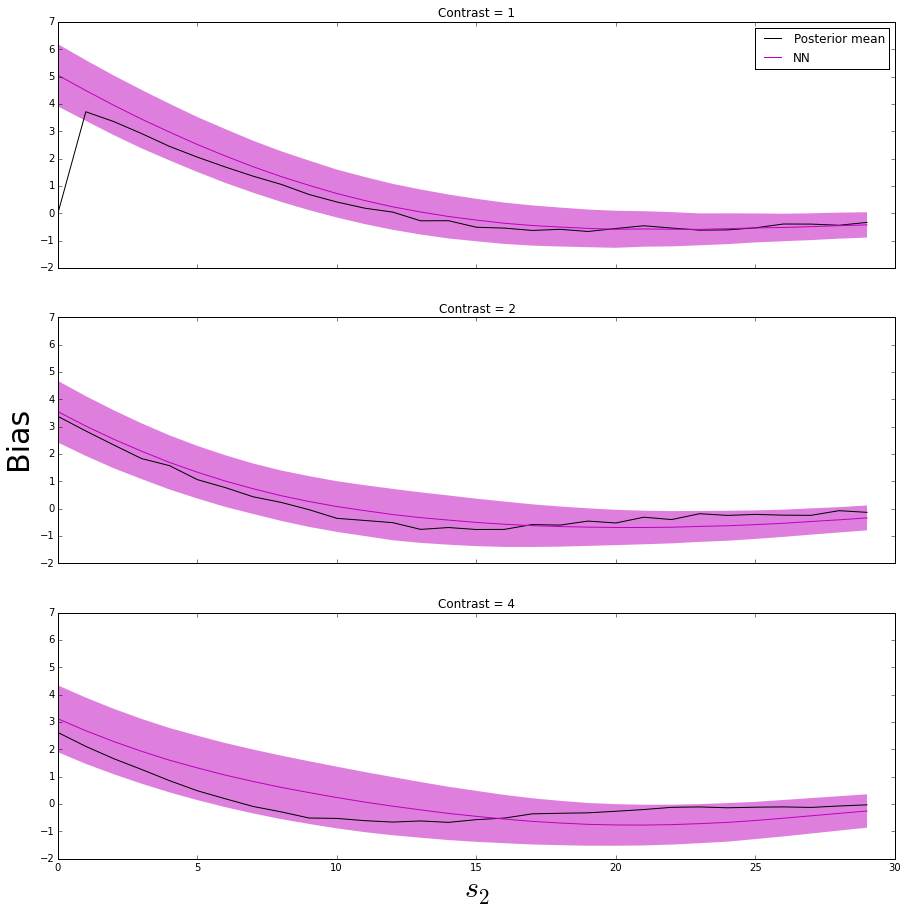

In [332]:
%matplotlib inline
f, ax = plt.subplots(3, sharex=True, sharey=True)
s = range(0, 30)
for i in range(len(c_arr)):
    neg_sd = np.mean(nn_stats['bias_s2'][i], axis=0) - np.std(nn_stats['bias_s2'][i], axis=0)
    pos_sd = np.mean(nn_stats['bias_s2'][i], axis=0) + np.std(nn_stats['bias_s2'][i], axis=0)
    ax[i].plot(post_stats['bias_s2'][i], c='k', label="Posterior mean")
    ax[i].plot(np.mean(nn_stats['bias_s2'][i], axis=0), c='m', label="NN")
    ax[i].set_title("Contrast = " + str(c_arr[i]))
    ax[i].fill_between(s, pos_sd, neg_sd, facecolor='m', alpha=.5, edgecolor="None", label="Posterior")
ax[2].set_xlabel(r'$s_2$',fontsize=30)
ax[1].set_ylabel('Bias' ,fontsize=30)
ax[0].legend(loc='upper right')
f.set_size_inches(15,15)

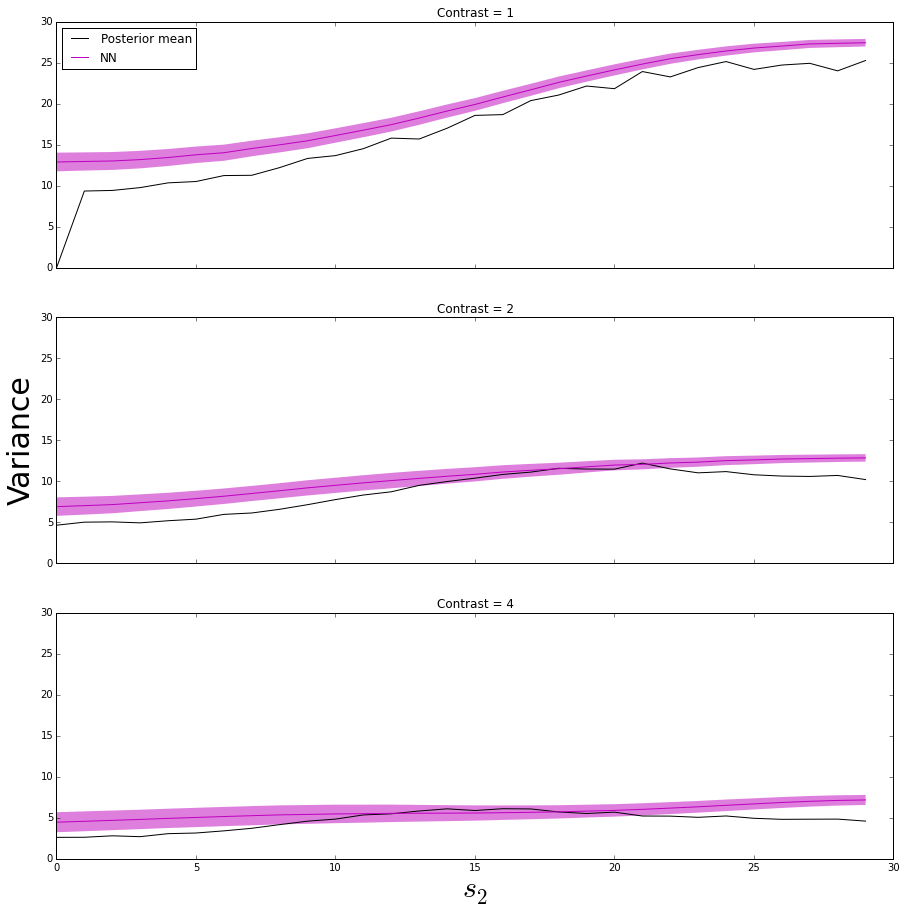

In [333]:
%matplotlib inline
f, ax = plt.subplots(3, sharex=True, sharey=True)
s = range(0, 30)
for i in range(len(c_arr)):
    neg_sd = np.mean(nn_stats['var_s2'][i], axis=0) - np.std(nn_stats['bias_s2'][i], axis=0)
    pos_sd = np.mean(nn_stats['var_s2'][i], axis=0) + np.std(nn_stats['bias_s2'][i], axis=0)
    ax[i].plot(post_stats['var_s2'][i], c='k', label="Posterior mean")
    ax[i].plot(np.mean(nn_stats['var_s2'][i], axis=0), c='m', label="NN")
    ax[i].set_title("Contrast = " + str(c_arr[i]))
    ax[i].fill_between(s, pos_sd, neg_sd, facecolor='m', alpha=.5, edgecolor="None", label="Posterior")
ax[2].set_xlabel(r'$s_2$',fontsize=30)
ax[1].set_ylabel('Variance' ,fontsize=30)
ax[0].legend(loc='upper left')
f.set_size_inches(15,15)

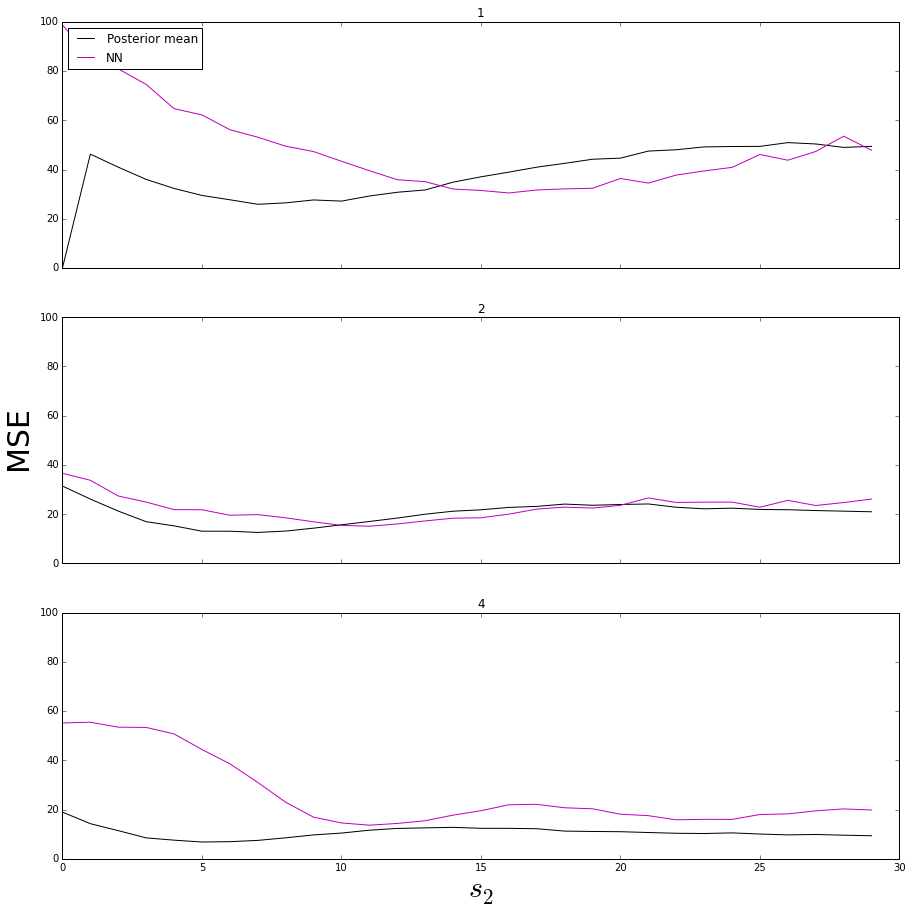

In [245]:
%matplotlib inline
f, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(len(c_arr)):
    ax[i].plot(post_stats['mse'][i], c='k', label="Posterior mean")
    ax[i].plot(nn_stats['mse'][i], c='m', label="NN")
    ax[i].set_title(c_arr[i])
ax[2].set_xlabel(r'$s_2$',fontsize=30)
ax[1].set_ylabel('MSE' ,fontsize=30)
ax[0].legend(loc='upper left')
f.set_size_inches(15,15)